In [1]:
# assign directory
import git
from pathlib import Path
import os
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from transform import *
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "dataset-preparation"))

data_dir  = os.path.join(ROOT_DIR, 'raw-data', 'ravdess','full-ravdess-wav')
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

## numpy representation

using `scipy.io.wavfile.read(filename)` to intake .wav audio files 

> returns 
> * rate, registing the hertz of the audio 
> * data, an array with each index representing a point in time for the audio and its value representing amplitude at said time 
>   * index position divided by the length of array represents its temporal occurence in seconds

In [2]:
from scipy.io import wavfile

In [3]:
wav_rates, wav_coeffs = zip(*[wavfile.read(file) for file in file_list])
wav_rates = np.array(wav_rates)
wav_coeffs = np.array(wav_coeffs, dtype="object")

/var/folders/tc/hb1c2fsd7hg15551387b8b6w0000gn/T/ipykernel_23839/3344179114.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wav_rates, wav_coeffs = zip(*[wavfile.read(file) for file in file_list])


In [4]:
assert len(wav_rates) == len(wav_rates), "Check for lossy data in .wav scipy numpy representation"
n = len(wav_rates)
n

1440

In [5]:
wav_lengths = pd.Series(wav_coeffs).apply(len) / wav_rates[0]

## info parsing to .csv

file naming conventions (from RAVDESS)

In [6]:
modalities = {
    "01": "full-AV", 
    "02": "video-only",
    "03": "audio-only"
} 

channels = {
    "01": "speech",
    "02": "song"
}

emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "suprised",
} 

intensities = {
    "01": "normal",
    "02": "strong"
}

statements = {
    "01": "Kids are talking by the door",
    "02": "Dogs are sitting by the door"
}

speaker_sex = ["female", "male"] 

In [7]:
ravdess_cols = ["modality", "channel", "emotion", "intensity", "statement", "repetition", "actor", "sex", "filename"]
rows = []

for f in file_names:
    if f != ".DS_Store":
        parsed_info = f[:-4].split("-")

        modality = modalities[parsed_info[0]]
        channel = channels[parsed_info[1]]
        emotion = emotions[parsed_info[2]]
        intensity = intensities[parsed_info[3]]
        sentence = statements[parsed_info[4]]
        rep = int(parsed_info[5])
        no1 = int(parsed_info[6])
        sx = speaker_sex[no1 % 2]

        rows.append({
            "modality": modality,
            "channel": channel,
            "emotion": emotion,
            "intensity": intensity,
            "statement": sentence,
            "repetition": rep,
            "actor": no1,
            "sex": sx,
            "filename": f
        })

ravdess_df = pd.DataFrame(rows, columns=ravdess_cols)


ravdess_df["length (s)"] = wav_lengths
ravdess_df["rate (Hz)"] = wav_rates
ravdess_df["amplitudes"] = wav_coeffs

ravdess_df.head()

,modality,channel,emotion,intensity,statement,repetition,actor,sex,filename,length (s),rate (Hz),amplitudes
0,audio-only,speech,fearful,normal,Dogs are sitting by the door,2,2,female,03-01-06-01-02-02-02.wav,3.737062,48000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0,..."
1,audio-only,speech,angry,normal,Dogs are sitting by the door,1,16,female,03-01-05-01-02-01-16.wav,3.903896,48000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,audio-only,speech,suprised,normal,Kids are talking by the door,1,14,female,03-01-08-01-01-01-14.wav,3.636979,48000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,audio-only,speech,fearful,normal,Dogs are sitting by the door,2,16,female,03-01-06-01-02-02-16.wav,3.570229,48000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,audio-only,speech,angry,normal,Dogs are sitting by the door,1,2,female,03-01-05-01-02-01-02.wav,3.770417,48000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
xport_name = "full-ravdess.csv"
EXPORT_DIR = os.path.join(ROOT_DIR, "raw-data", "ravdess")
EXPORT_PATH = os.path.join(EXPORT_DIR, xport_name)

ravdess_df.to_csv(EXPORT_PATH)

## npz representation export

In [ ]:
EXPORT_DIR = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-npz')

for f in np.arange(len(file_list)):
    coef = wav_coeffs[f]
    file_name = file_list[f][-24:-4] ## removes the .wav naming convention

    np.savez(os.path.join(EXPORT_DIR, file_name))

## banding

consideration for a "banding method" to group adjacent audio bytes in a similar fashion to how the image teams doing 

* tied to the transformation in use 

# Wavelet representation
Morlet continuous wavelet transform on some example files to start

In [9]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

In [10]:
test_file_idx = 42
print(ravdess_df.iloc[test_file_idx])

rate, signal = wavfile.read(file_list[test_file_idx])

wavelet = 'cmor1.5-1.0' # complex morlet: bandwidth = 1.5, center frequency = 1.0
low_freq, high_freq = 80, 4000  # typical range for human speech
num_scales = 100  # can be adjusted for computational efficiency

frequencies = np.logspace(np.log10(low_freq), np.log10(high_freq), num_scales)
scales = pywt.frequency2scale(wavelet, frequencies / rate)
coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/rate)

modality                                             audio-only
channel                                                  speech
emotion                                                     sad
intensity                                                normal
statement                          Dogs are sitting by the door
repetition                                                    2
actor                                                        23
sex                                                        male
filename                               03-01-04-01-02-02-23.wav
length (s)                                             3.670333
rate (Hz)                                                 48000
amplitudes    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 42, dtype: object


/var/folders/tc/hb1c2fsd7hg15551387b8b6w0000gn/T/ipykernel_23839/3210993221.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, signal = wavfile.read(file_list[test_file_idx])


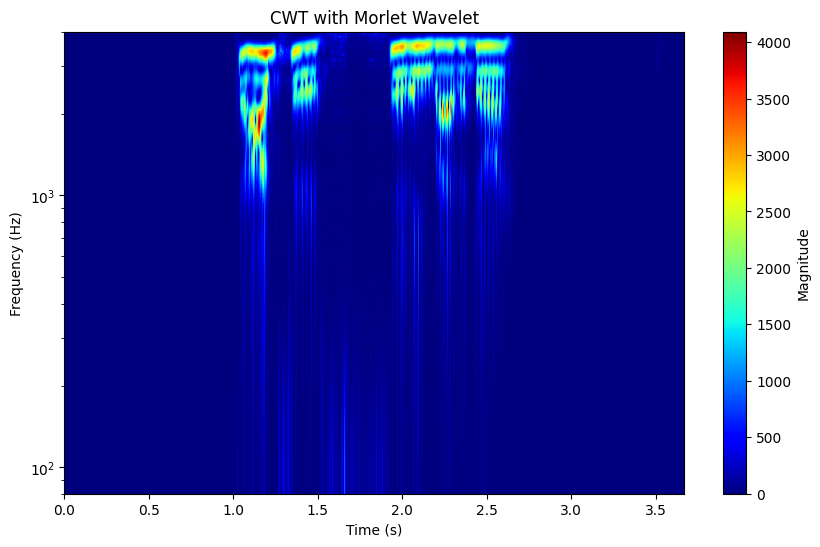

In [11]:
plt.figure(figsize=(10, 6))
plt.imshow(
    np.abs(coefs),
    aspect='auto',
    cmap='jet',
    extent=[0, len(signal)/rate, low_freq, high_freq]
)
plt.colorbar(label='Magnitude')
plt.yscale('log') # log scale frequency axis
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('CWT with Morlet Wavelet')
plt.show()

In [12]:
# generalize above logic into function

def cwt_file(filename, wavelet='cmor1.5-1.0', low_freq=80, high_freq=4000, num_scales=100, visualize=False, title='CWT with Morlet Wavelet'):
    rate, signal = wavfile.read(os.path.join(data_dir, filename)) # currently references global data_dir
    frequencies = np.logspace(np.log10(low_freq), np.log10(high_freq), num_scales)
    scales = pywt.frequency2scale(wavelet, frequencies / rate)
    coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/rate)

    if visualize:
        plt.figure(figsize=(10, 6))
        plt.imshow(
            np.abs(coefs),
            aspect='auto',
            cmap='jet',
            extent=[0, len(signal)/rate, low_freq, high_freq]
        )
        plt.colorbar(label='Magnitude')
        plt.yscale('log')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(title)
        plt.show()

    return coefs, freqs

In [13]:
# compare male versus female

from functools import reduce

def homogenize(df, *cols):
    return df[reduce(lambda a, b: a & b, (df[col] == df[col][0] for col in cols), np.ones(df.shape[0]))]

hom_df = homogenize(ravdess_df, 'statement', 'emotion', 'intensity')
male_vs_female = hom_df.groupby('sex').first()
male_vs_female

,modality,channel,emotion,intensity,statement,repetition,actor,filename,length (s),rate (Hz),amplitudes
sex,,,,,,,,,,,
female,audio-only,speech,fearful,normal,Dogs are sitting by the door,2,2,03-01-06-01-02-02-02.wav,3.737062,48000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0,..."
male,audio-only,speech,fearful,normal,Dogs are sitting by the door,2,17,03-01-06-01-02-02-17.wav,3.636958,48000,"[2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, ..."


/var/folders/tc/hb1c2fsd7hg15551387b8b6w0000gn/T/ipykernel_23839/363451737.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, signal = wavfile.read(os.path.join(data_dir, filename))


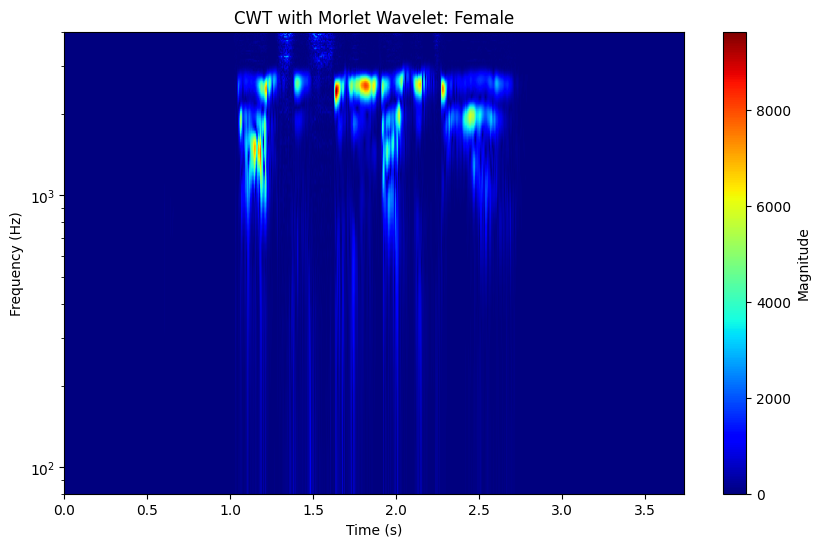

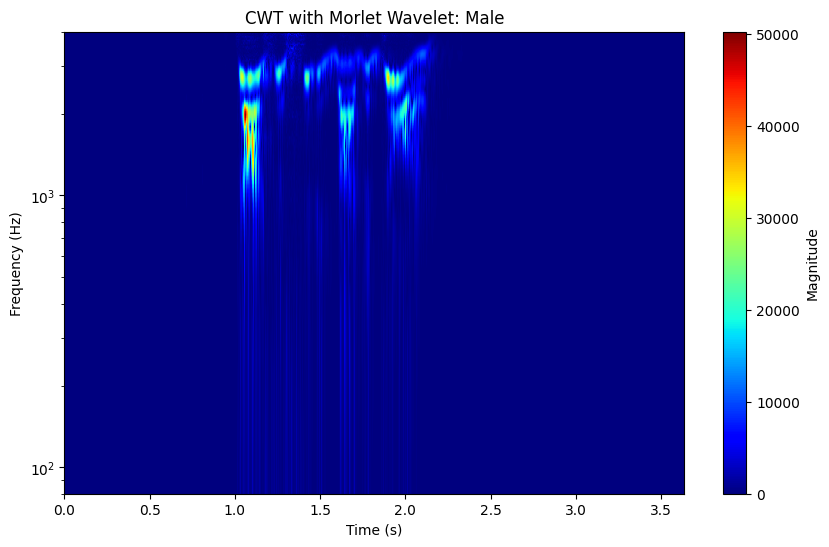

In [14]:
for sex, filename in zip(male_vs_female.index, male_vs_female['filename']):
    cwt_file(filename, visualize=True, title=f'CWT with Morlet Wavelet: {sex.capitalize()}')